# Clip HYRAS data to catchment extent

This notebook is used to clip HYRAS data to the extent of one catchment, specified by the parameter `CAMELS_ID` for one HYRAS variable, specified by the parameter `HYRAS_VARIABLE`. We calculate different statistics for the variable (spatial mean, std, min, max, quartiles) and save them as timeseries in .csv format. Additionally, the parameter `SAVE_NETCDF` determines wheter the clipped netCDF is also saved to disk. Note that saving the netCDF files makes the execution of the notebook significantly slower.  

**Attention**: in the `rioxarray.clip()` method, we set `all_touched=True`. This way, all pixels touched by geometries will be burned in. If `all_touched=False`, only those pixels where the center is within the catchment are used. We decided to got for the option `all_touched=True`, as e.g. precipitation is often underestimated in hydrology. This is especially important for small catchments, where the different methods produce very different results. On the other hand, with `all_touched=True`, we make sure that we generate data for small catchments at all.  

This notebook is meant to be executed by papermill.

In [1]:
import os
import time
import json

import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import dask
import contextily as ctx

from camelsp import Station

/home/alexd/miniconda3/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [11]:
CAMELS_ID = "DE910920"
HYRAS_VARIABLE = "Humidity"
INPUT_PATH = "../input_data"
RESULT_PATH = "../output_data"
WEIGHTED_STATISTICS = True
SAVE_NETCDF = True # save the netcdf file, can be very slow

In [12]:
# import exactextract only if WEIGHTED_STATISTICS is True
if WEIGHTED_STATISTICS:
    from exactextract import exact_extract

In [13]:
start_time = time.time()

In [14]:
# check if the result folder exists
if not os.path.exists(f"{RESULT_PATH}/{CAMELS_ID}"):
    os.makedirs(f"{RESULT_PATH}/{CAMELS_ID}")

# create a metadata json file to store information about the notebook run
if not os.path.exists(f"{RESULT_PATH}/{CAMELS_ID}/metadata.json"):
    with open(f"{RESULT_PATH}/{CAMELS_ID}/metadata.json", "w") as f:
        json.dump({}, f)


In [15]:
var_mapping = {
    "Humidity": dict(variable_name = "hurs", datapath = f"{INPUT_PATH}/hyras/Humidity/hurs_hyras_5_1951_2020_v5-0_de.nc"),
    "Precipitation": dict(variable_name = "pr", datapath = f"{INPUT_PATH}/hyras/Precipitation/pr_hyras_1_1931_2020_v5-0_de.nc"),
    "RadiationGlobal": dict(variable_name = "rsds", datapath = f"{INPUT_PATH}/hyras/RadiationGlobal/*.nc"),
    "TemperatureMax": dict(variable_name = "tasmax", datapath = f"{INPUT_PATH}/hyras/TemperatureMax/tasmax_hyras_5_1951_2020_v5-0_de.nc"),
    "TemperatureMin": dict(variable_name = "tasmin", datapath = f"{INPUT_PATH}/hyras/TemperatureMin/tasmin_hyras_5_1951_2020_v5-0_de.nc"),
    "TemperatureMean": dict(variable_name = "tas", datapath = f"{INPUT_PATH}/hyras/TemperatureMean/tas_hyras_5_1951_2020_v5-0_de.nc"),
}

# get the variable and data_path
variable = var_mapping[HYRAS_VARIABLE]["variable_name"]
data_path = var_mapping[HYRAS_VARIABLE]["datapath"]

# empty list to store warnings
warnings = []

## Get Input data

In [16]:
# initialize station
s = Station(CAMELS_ID)

# get catchment shape
catchment = s.get_catchment("merit_hydro")

# stop the notebook here if no merit hydro catchment is found
if catchment is None:
    print("No MERIT Hydro catchment available for this Station")
    warnings.append("ERROR: No MERIT Hydro catchment available for this Station")

    metadata = {
        CAMELS_ID: {
            HYRAS_VARIABLE: {
                "start_time": pd.to_datetime(start_time, unit="s").strftime("%Y-%m-%d %H:%M:%S"),
                "weighted_statistics": WEIGHTED_STATISTICS,
                "warnings": warnings
            }
        }
    }

    # update metadata
    with open(f"{RESULT_PATH}/{CAMELS_ID}/metadata.json", "r") as f:
        metadata_old = json.load(f)

    # Check if CAMELS_ID key exists, if not, create it
    if CAMELS_ID not in metadata_old:
        metadata_old[CAMELS_ID] = {}

    # Update the dictionary
    metadata_old[CAMELS_ID].update(metadata[CAMELS_ID])

    with open(f"{RESULT_PATH}/{CAMELS_ID}/metadata.json", "w") as f:
        json.dump(metadata_old, f, indent=4)

    raise ValueError("No MERIT Hydro catchment available for this Station")
else:
    # save the catchment shape as a geojson file to output_data folder
    catchment.to_file(f"{RESULT_PATH}/{CAMELS_ID}/{CAMELS_ID}_merit_hydro_catchment.geojson", driver="GeoJSON")

# transform crs to EPSG:3034 to be in the same crs as the hyras data
catchment = catchment.to_crs(epsg=3034)

In [17]:
# open hyras data, chunks="auto" with unify_chunks() produced the fastest results
ds = xr.open_mfdataset(data_path, combine="by_coords", chunks="auto").unify_chunks()

# if variable is Precipitation, select from 1950
if HYRAS_VARIABLE == 'Precipitation':
    ds = ds.sel(time=slice('1951', None))

# need to set the crs (EPSG:3034)
ds.rio.write_crs("EPSG:3034", inplace=True)

# drop variable time_bnds, x_bnds_clipped_clipped_clipped, y_bnds and coordinate crs_HYRAS (makes problems with xarray)
ds = ds.drop_vars("time_bnds")
ds = ds.drop_vars("x_bnds")
ds = ds.drop_vars("y_bnds")

# set the spatial dimensions
ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

<xarray.Dataset>
Dimensions:             (time: 25568, y: 220, x: 240)
Coordinates:
  * time                (time) datetime64[ns] 1951-01-01T12:00:00 ... 2020-12...
    lon                 (y, x) float64 dask.array<chunksize=(220, 240), meta=np.ndarray>
    lat                 (y, x) float64 dask.array<chunksize=(220, 240), meta=np.ndarray>
  * x                   (x) float32 3.502e+06 3.508e+06 ... 4.692e+06 4.698e+06
  * y                   (y) float32 2.102e+06 2.108e+06 ... 3.192e+06 3.198e+06
    crs_HYRAS           int64 0
Data variables:
    hurs                (time, y, x) float32 dask.array<chunksize=(635, 220, 240), meta=np.ndarray>
    number_of_stations  (time) float64 dask.array<chunksize=(635,), meta=np.ndarray>
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_humidity_dataset_(HYRAS-DE HURS)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 22:29:56
    filename:               hurs_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_hurs_v5.0_1951_2020_day_00638D1F64

## Do the Clip

In [18]:
# clip the data to the catchment shape, all_touched=True to get all pixels that are at least partially in the catchment
ds_clipped = ds.rio.clip(catchment.geometry, all_touched=True)

# load the data into memory, this yielded the fastest computation times
ds_clipped = ds_clipped.load()

## Plot Results

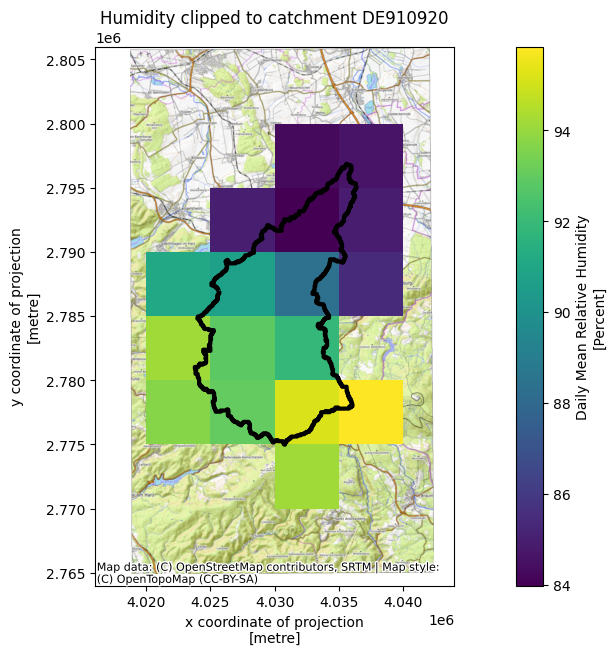

In [19]:
data_1d = False

# check dimensionality of clipped data, raster plot and calculating weighted statistics with exactaxtract can only be done if shape is >= (2, 2)
if 1 in ds_clipped[variable].isel(time=0).shape:
    data_1d = True

# check dimensionality of clipped data, raster plot can only be done if shape is >= (2, 2)
if data_1d:
    print("Clipped data has dimensionality of 1, cannot create raster plot")
    warnings.append("Clipped data has dimensionality of 1, cannot create raster plot")
    
else:
    # plot ds_clipped together with gdf_polygon
    fig_spatial, ax = plt.subplots(figsize=(16, 7))

    # plot ds_clipped on top
    ds_clipped[variable].isel(time=0).plot(alpha=1, ax=ax, cmap="viridis")

    # plot catchment first, big red border, no fill
    catchment.plot(ax=ax, color="none", edgecolor="black", linewidth=3)

    # add basemap but this needs an in internet connection and sometimes takes a while
    try:
        ctx.add_basemap(ax, crs=ds_clipped.rio.crs.to_string(), source=ctx.providers.OpenTopoMap)
    except Exception as e:
        print(f"Basemap loading not succesfull: {e}")
        warnings.append(f"Basemap loading not succesfull: {e}")
        
    # Increase x and y limits
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_xlim(xmin - 0.2*(xmax-xmin), xmax + 0.2*(xmax-xmin))
    ax.set_ylim(ymin - 0.2*(ymax-ymin), ymax + 0.2*(ymax-ymin))

    # Add a title
    ax.set_title(f"{HYRAS_VARIABLE} clipped to catchment {CAMELS_ID}")

    plt.show()


## Aggregate to timeseries and calculate statistics

In [20]:
# Remove the grid_mapping key from the variable's attributes (problems with xarray)
ds_clipped[variable].attrs.pop("grid_mapping", None)

# drop variable crs_HYRAS (problems with xarray)
ds_clipped = ds_clipped.drop_vars("crs_HYRAS")

In [21]:
if WEIGHTED_STATISTICS:
    # check dimensionality of clipped data, exactextract cannot handle dimensionality==1 -> shape must be >= (2, 2)
    if data_1d:
        print("Clipped data has dimensionality of 1, cannot calculate weighted statistics")
        warnings.append("ERROR: Clipped data has dimensionality of 1, cannot calculate weighted statistics")

        metadata = {
            CAMELS_ID: {
                HYRAS_VARIABLE: {
                    "start_time": pd.to_datetime(start_time, unit="s").strftime("%Y-%m-%d %H:%M:%S"),
                    "catchment_area_km2": round(catchment.area.values[0] / 1e6, 2),
                    "weighted_statistics": WEIGHTED_STATISTICS,
                    "warnings": warnings
                }
            }
        }

        # update metadata
        with open(f"{RESULT_PATH}/{CAMELS_ID}/metadata.json", "r") as f:
            metadata_old = json.load(f)

        # Check if CAMELS_ID key exists, if not, create it
        if CAMELS_ID not in metadata_old:
            metadata_old[CAMELS_ID] = {}

        # Update the dictionary
        metadata_old[CAMELS_ID].update(metadata[CAMELS_ID])

        with open(f"{RESULT_PATH}/{CAMELS_ID}/metadata.json", "w") as f:
            json.dump(metadata_old, f, indent=4)

        # stop the notebook here
        raise ValueError("Clipped data has dimensionality of 1, cannot calculate weighted statistics")
    
    else:
        # list of statistics to calculate
        statistics = ["mean", "min", "median", "max", "stdev"]

        # calculate the weighted statistics
        df_weighted = exact_extract(ds_clipped[variable], catchment, statistics, output="pandas")
        
        # process df_weighted to get it to the right format
        df = df_weighted.T

        # get the time index from the xarray dataset
        time_index = ds_clipped.time.values

        # create a list of dataframes, each dataframe contains the timeseries for one statistic
        sliced_dfs = [df.iloc[i:i+len(time_index)] for i in range(0, len(df), len(time_index))]

        # set the index to the time values and rename the columns
        for i, df in enumerate(sliced_dfs):
            df.index = time_index
            df.columns = [f"{variable}_{statistics[i]}"]

        # concatenate the dataframes
        df_timeseries = pd.concat(sliced_dfs, axis=1)

        df_timeseries

In [22]:
if not WEIGHTED_STATISTICS:
    # Define the computations
    mean = ds_clipped[variable].mean(dim=["x", "y"])
    std = ds_clipped[variable].std(dim=["x", "y"])
    min_val = ds_clipped[variable].min(dim=["x", "y"])
    max_val = ds_clipped[variable].max(dim=["x", "y"])
    quartiles = [25, 50, 75]
    try:
        quantiles = [ds_clipped[variable].quantile(p/100, dim=["x", "y"]) for p in quartiles]
    # if there is a ValueError, try again with rechunking the y dimension
    except ValueError:
        quantiles = [ds_clipped[variable].chunk(dict(y=-1)).quantile(p/100, dim=["x", "y"]) for p in quartiles]

    # Compute the results in parallel
    mean, std, min_val, max_val, *quantiles = dask.compute(mean, std, min_val, max_val, *quantiles)

    # Convert the results to pandas DataFrames
    df_mean = mean.to_dataframe()
    df_mean.columns = [f"{variable}_mean"]

    df_std = std.to_dataframe()
    df_std.columns = [f"{variable}_stdev"]

    df_min = min_val.to_dataframe()
    df_min.columns = [f"{variable}_min"]

    df_max = max_val.to_dataframe()
    df_max.columns = [f"{variable}_max"]

    df_quartiles = pd.DataFrame()
    for p, q in zip(quartiles, quantiles):
        df_p = q.to_dataframe()
        df_p.drop(columns=["quantile"], inplace=True)
        df_p.columns = [f"{variable}_quartile{p}"]
        df_quartiles = pd.concat([df_quartiles, df_p], axis=1)

    # Concatenate all dataframes
    df_timeseries = pd.concat([df_mean, df_std, df_min, df_max, df_quartiles], axis=1)

    df_timeseries


## Plot timeseries results

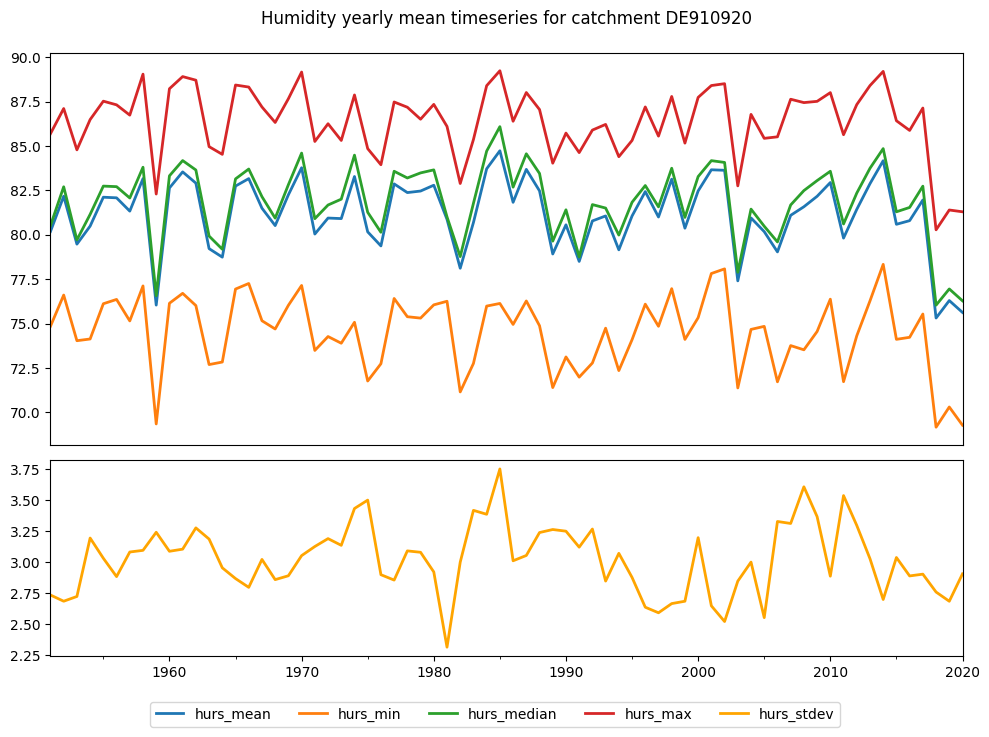

In [23]:
fig_timeseries = plt.figure(figsize=(10, 7))

# Define the height ratios for the subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# Plot all columns except 'hurs_std' in the first subplot
ax0 = plt.subplot(gs[0])
lines1 = df_timeseries.drop(columns=[f"{variable}_stdev"]).groupby(pd.Grouper(freq='Y')).mean().plot(ax=ax0, lw=2, legend=False)
ax0.set_title(f"{HYRAS_VARIABLE} yearly mean timeseries for catchment {CAMELS_ID}\n")
ax0.xaxis.set_visible(False)  # Remove x-axis

# Plot 'hurs_std' in the second subplot
ax1 = plt.subplot(gs[1])
lines2 = df_timeseries[f"{variable}_stdev"].groupby(pd.Grouper(freq='Y')).mean().plot(ax=ax1, lw=2, color='orange', legend=False)

# Create a shared legend
lines = lines1.get_lines() + lines2.get_lines()
labels = [line.get_label() for line in lines]

# Move the legend outside of the plot to the bottom
fig_timeseries.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(lines))

plt.tight_layout()
plt.show()

## Save results

In [24]:
# Make output directory if it does not exist
os.makedirs(f"{RESULT_PATH}/{CAMELS_ID}/plots", exist_ok=True)
os.makedirs(f"{RESULT_PATH}/{CAMELS_ID}/data", exist_ok=True)

# Save figures
if not data_1d:
    fig_spatial.savefig(f"{RESULT_PATH}/{CAMELS_ID}/plots/{HYRAS_VARIABLE}_catchment_clipped.png", dpi=300, bbox_inches="tight")
fig_timeseries.savefig(f"{RESULT_PATH}/{CAMELS_ID}/plots/{HYRAS_VARIABLE}_timeseries.png", dpi=300, bbox_inches="tight")

# Save timeseries data
df_timeseries.to_csv(f"{RESULT_PATH}/{CAMELS_ID}/data/{CAMELS_ID}_{HYRAS_VARIABLE}.csv")


# Save clipped data
if SAVE_NETCDF:
    ds_clipped.to_netcdf(f"{RESULT_PATH}/{CAMELS_ID}/data/{CAMELS_ID}_{HYRAS_VARIABLE}_clipped.nc")


In [25]:
end_time = time.time()

### Generate some metadata for the run and save as .json

In [26]:
n_hyras_cells = int(ds_clipped[variable].isel(time=0).count()) # count the number of cells with data
cell_area = 1000 * 1000 if HYRAS_VARIABLE == "Precipitation" else 5000 * 5000 # cell area in m2

metadata = {
    CAMELS_ID: {
        HYRAS_VARIABLE: {
            "start_time": pd.to_datetime(start_time, unit="s").strftime("%Y-%m-%d %H:%M:%S"),
            "runtime_seconds": round(end_time-start_time, 2),
            "n_hyras_cells": n_hyras_cells,
            "hyras_area_km2": n_hyras_cells * cell_area / 1e6,
            "catchment_area_km2": round(catchment.area.values[0] / 1e6, 2),
            "weighted_statistics": WEIGHTED_STATISTICS,
            "warnings": warnings
        }
    }
}

# update metadata
with open(f"{RESULT_PATH}/{CAMELS_ID}/metadata.json", "r") as f:
    metadata_old = json.load(f)

# Check if CAMELS_ID key exists, if not, create it
if CAMELS_ID not in metadata_old:
    metadata_old[CAMELS_ID] = {}

# Update the dictionary
metadata_old[CAMELS_ID].update(metadata[CAMELS_ID])

with open(f"{RESULT_PATH}/{CAMELS_ID}/metadata.json", "w") as f:
    json.dump(metadata_old, f, indent=4)

metadata

{'DE910920': {'Humidity': {'start_time': '2024-02-29 10:10:20',
   'runtime_seconds': 336.92,
   'n_hyras_cells': 17,
   'hyras_area_km2': 425.0,
   'catchment_area_km2': 150.21,
   'weighted_statistics': True,
   'warnings': []}}}

In [27]:
# close xarray datasets
ds.close()
ds_clipped.close()